In [1]:
from torch_geometric.datasets import NELL
from torch_geometric.datasets import KarateClub
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, SAGEConv, GATConv,RGCNConv
import torch

dataset = KarateClub()

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
# data = dataset[0]  # Get the first graph object.

print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [2]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class RGCN(torch.nn.Module):
    def __init__(self, in_c, hid_c, out_c):
        super(RGCN,self).__init__()    # 构造函数

        self.conv1 = GCNConv(in_channels=in_c, out_channels=hid_c)
        self.conv2 = GCNConv(in_channels=hid_c, out_channels=out_c)
  
    def forward(self, data):
        x, edge_index = data.x, data.edge_index    # x:节点特征矩阵; edge_index:COO格式的图形连接，维度[2,边的数量]，数据：[ [源节点],[目标节点] ]
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        
        x1 = F.log_softmax(x, dim=1)
        
        return x1, x

model = RGCN(in_c=dataset.num_node_features,hid_c=100,out_c=dataset.num_node_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

print(model(data))

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out1, out = model(data)
    # 交叉熵损失
    loss = F.nll_loss(out1[data.train_mask], data.y[data.train_mask])       # 负对数似然。
    loss.backward()
    optimizer.step()
    print('epoch:',epoch, 'loss:',loss.item())  

print(out)

(tensor([[-3.5097, -3.5412, -3.6191,  ..., -3.4946, -3.4863, -3.5466],
        [-3.5053, -3.5482, -3.5715,  ..., -3.5225, -3.5200, -3.5611],
        [-3.5503, -3.5487, -3.5660,  ..., -3.5294, -3.5178, -3.5211],
        ...,
        [-3.5359, -3.5390, -3.5538,  ..., -3.5110, -3.4844, -3.5701],
        [-3.5832, -3.5174, -3.5633,  ..., -3.5031, -3.4386, -3.6251],
        [-3.5926, -3.5290, -3.5713,  ..., -3.5022, -3.4554, -3.6038]],
       grad_fn=<LogSoftmaxBackward>), tensor([[ 0.0304, -0.0011, -0.0790,  ...,  0.0455,  0.0538, -0.0065],
        [ 0.0284, -0.0146, -0.0379,  ...,  0.0112,  0.0136, -0.0275],
        [-0.0187, -0.0171, -0.0344,  ...,  0.0021,  0.0138,  0.0105],
        ...,
        [-0.0020, -0.0051, -0.0198,  ...,  0.0229,  0.0495, -0.0362],
        [-0.0421,  0.0237, -0.0222,  ...,  0.0379,  0.1025, -0.0840],
        [-0.0535,  0.0101, -0.0322,  ...,  0.0370,  0.0838, -0.0647]],
       grad_fn=<AddBackward0>))
epoch: 0 loss: 3.544055223464966
epoch: 1 loss: 3.53158283233

epoch: 281 loss: 0.1030738353729248
epoch: 282 loss: 0.10207310318946838
epoch: 283 loss: 0.10108567029237747
epoch: 284 loss: 0.1001136526465416
epoch: 285 loss: 0.09915568679571152
epoch: 286 loss: 0.09821117669343948
epoch: 287 loss: 0.09728024899959564
epoch: 288 loss: 0.09636280685663223
epoch: 289 loss: 0.09545814990997314
epoch: 290 loss: 0.09456592053174973
epoch: 291 loss: 0.09368658810853958
epoch: 292 loss: 0.09282048046588898
epoch: 293 loss: 0.09196650981903076
epoch: 294 loss: 0.09112459421157837
epoch: 295 loss: 0.0902942642569542
epoch: 296 loss: 0.08947457373142242
epoch: 297 loss: 0.08866658061742783
epoch: 298 loss: 0.08786997944116592
epoch: 299 loss: 0.08708494156599045
epoch: 300 loss: 0.0863097533583641
epoch: 301 loss: 0.08554637432098389
epoch: 302 loss: 0.08479408919811249
epoch: 303 loss: 0.08405192196369171
epoch: 304 loss: 0.08331946283578873
epoch: 305 loss: 0.08259709179401398
epoch: 306 loss: 0.08188417553901672
epoch: 307 loss: 0.08118164539337158
epoch

In [3]:
import pandas as pd
from sklearn import cluster
from sklearn import metrics

out=out.cpu().detach().numpy()
model = cluster.KMeans(n_clusters=4)
model.fit(out)

y_predict = model.predict(out)

# Calinski-Harabaz Index：越大越好
# Silhouette Coefficient：轮廓系数（越大越好)
print('Calinski-Harabaz Index：',metrics.calinski_harabasz_score(out,y_predict))
print('Silhouette Coefficient：',metrics.silhouette_score(out,y_predict))

Calinski-Harabaz Index： 37.447999736749445
Silhouette Coefficient： 0.45621094


In [4]:
from sklearn.manifold import TSNE
t_sne = TSNE()
data=t_sne.fit_transform(out)
data=pd.DataFrame(data)
data = pd.DataFrame(data,index=y_predict)
data_tsne = pd.DataFrame(t_sne.embedding_, index =y_predict)
data_tsne

,0,1
0,87.243324,-29.089815
0,44.904957,-44.577423
0,58.422234,-26.015520
3,41.585373,-8.468280
2,47.248684,17.825443
2,45.481873,58.580647
2,69.818039,10.933814
1,-15.511182,-28.528765
1,-33.722057,-17.421339
1,-12.428071,38.585865


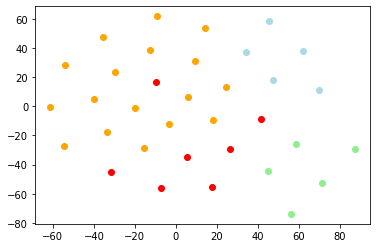

In [5]:
from matplotlib import pyplot as plt
d = data_tsne[data_tsne.index == 0]     #找出聚类类别为0的数据对应的降维结果
plt.scatter(d[0], d[1],c='lightgreen',marker='o')
d = data_tsne[data_tsne.index == 1]
plt.scatter(d[0], d[1], c='orange',	marker='o')
d = data_tsne[data_tsne.index == 2]
plt.scatter(d[0], d[1], c='lightblue',marker='o')
d = data_tsne[data_tsne.index == 3]
plt.scatter(d[0], d[1], c='red',marker='o')